# Imaging with Stride

In this notebook, we will apply what we have seen previously to image a 2D section of the human breast using full-waveform inversion (FWI) in Stride.

FWI is a tomographic imaging technique, originally developed in geophysics, that solves a local optimisation problem in order to find the acoustic properties (usually speed of sound) of some imaged region. 

Given some data that we have collected or observed $d_{obs}$ and some data that we have modelled numerically $d_{mod}$, FWI solves the problem,

$$
v_p^* = argmin_{v_p} J(v_p, d_{obs}, d_{mod})
$$
$$
s.t.\; \mathbf{L}(d_{mod}, v_p) = \mathbf{0}
$$

to find the speed of sound $v_p$, where $J(v_p, d_{obs}, d_{mod})$ is a scalar loss function and $\mathbf{L}(d_{mod},v_p) = \mathbf{0}$ is a system of PDEs.

Most generally, we use the L2-norm of the distance between $d_{obs}$ and $d_{mod}$ as the loss function, and the acoustic wave equation as the PDE. The problem then becomes,

$$
v_p^* = argmin_{v_p} \left\langle \frac{1}{2} \left( p(v_p) \delta(\mathbf{x}-\mathbf{x}_0) - d_{obs} \right) ^2, 1 \right\rangle
$$
$$
s.t.\; \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p - s = 0
$$

where $\left\langle \alpha, \beta \right\rangle = \int_{t_0}^{t_1}\int_{\Omega} \alpha \cdot \beta d\mathbf{x}^3dt$ for $t \in [t_0, t_1]$ and $\mathbf{x} \in \Omega$, $\delta(x)$ is the sampling Dirac delta, $\mathbf{x}_0$ is the location of receivers in the region, $p$ is the pressure, and $s$ is a source term.

In FWI, we solve this problem by using a local optimisation method like gradient descent, and we calculate the gradient of the problem using the adjoint method or, what is the same, the procedure that we introduced in the first notebook of this tutorial.

## Mosaic runtime

Before we proceed, let's start the Mosaic runtime.

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2)
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 140110629636848, uid=head, address=CC2416, port=3000, state=listening>
Sending msg hand to head from monitorReceived msg shake from head at monitorMONITOR         Listening at <CommsManager object at 140109389383760, uid=monitor, address=CC2416, port=3006, state=listening>
WAREHOUSE       Listening at <CommsManager object at 140109389389232, uid=warehouse, address=CC2416, port=3007, state=listening>
Sending msg hand to monitor from node:0Received msg shake from monitor at node:0NODE:0          Listening at <CommsManager object at 140109389390672, uid=node:0, address=CC2416, port=3008, state=listening>
Sending msg hand to node:0 from worker:0:0Received msg shake from node:0 at worker:0:0WORKER:0:0      Listening at <CommsManager object at 140109389396816, uid=worker:0:0, address=CC2416, port=3009, state=listening>
Sending msg hand to node:0 from worker:0:1Received msg shake from node:0 at worker:0:1WORKER:0:1      Listening at <CommsM

## Problem definition

Let's start by defining out problem as usual, starting with the spatiotemporal grid.

In [2]:
from stride import Space, Time, Grid
%matplotlib notebook

space = Space(shape=(356, 385), extra=(50, 50), absorbing=(40, 40), spacing=0.5e-3)
time = Time(start=0.0e-6, step=0.08e-6, num=2500)

grid = Grid(space, time)

We create the problem object.

In [3]:
from stride import Problem

problem = Problem(name='breast2D', space=space, time=time)

And we start filling it up we our transducers and geometry.

In [4]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

We are going to populate our acquisition sequence with 120 shots (one for each location in the geoemtry). During each shot, a different location is going to act as the source and the rest of them are going to act as receivers.

We can easily do this in Stride by calling the `default()` method of the `stride.Acquisitions` object.

In [5]:
from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

Now, let's load our breast model.

In [6]:
from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
vp_true.load('../examples/breast2D/data/anastasio2D-TrueModel.h5')

problem.medium.add(vp_true)

To get a plot of all components of the problem together, we can call the utility function `plot()` on the problem object.

<IPython.core.display.Javascript object>


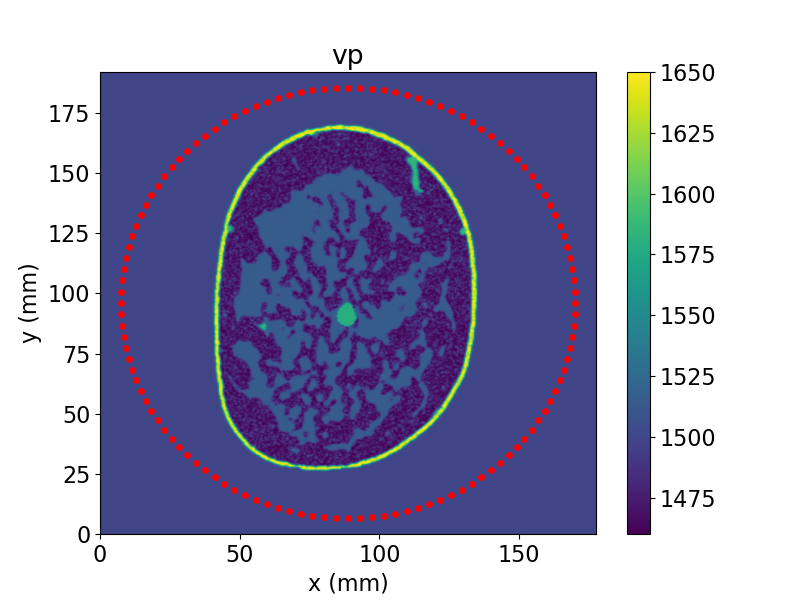

QApplication: invalid style override passed, ignoring it.
    Available styles: Windows, Fusion


<IPython.core.display.Javascript object>


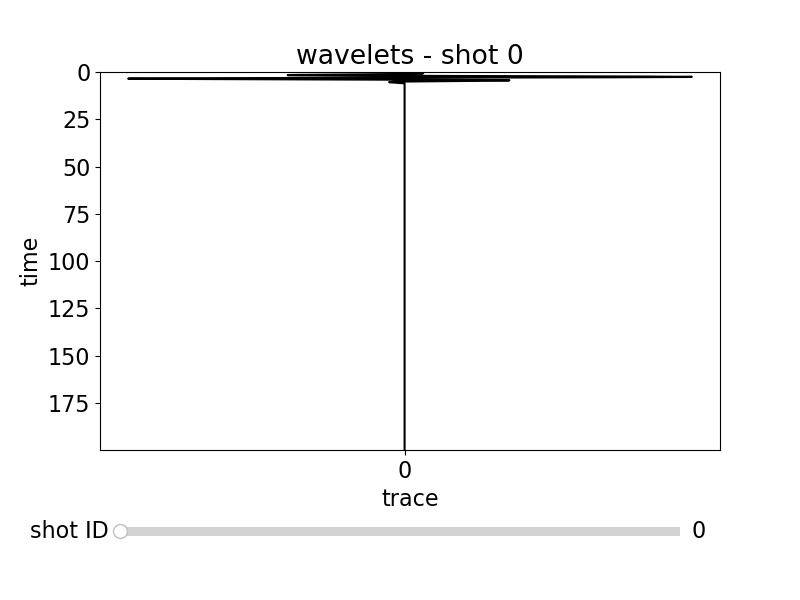

In [7]:
# Plot all components of the problem
problem.plot()

## Modelling operator

Once we have generated our problem, we can create a PDE on which to run our forward problem. In this case, we choose the isotropic acoustic wave equation.

We instantiate our PDE using `remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [8]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

## Forward problem - Generating observed data

Before we can proceed with the imaging bit, we need to simulate the acquisition of some observed data.

Here, we will exploit the parallelisation capabilities of Mosaic to run different shots in parallel in each available worker. We do this with an asynchronous for loop using `@runtime.async_for(<iterable>)`. In the previous code section, the async function `loop()` is called as many times as there are shots in the acquisitions and, for each shot, it is assigned a worker.

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
WORKER:0:0      Default Devito configuration:
WORKER:0:0      	 * autotuning=['aggressive', 'runtime']
WORKER:0:0      	 * develop-mode=False
WORKER:0:0      	 * mpi=False
WORKER:0:0      	 * log-level=DEBUG
WORKER:0:0      	 * language=openmp
WORKER:0:1      Default Devito configuration:
WORKER:0:1      	 * autotuning=['aggressive', 'runtime']
WORKER:0:1      	 * develop-mode=False
WORKER:0:1      	 * mpi=False
WORKER:0:1      	 * log-level=DEBUG
WORKER:0:1      	 * language=openmp
WORKER:0:0      (ShotID 0) Preparing to run state for shot
WORKER:0:0      (ShotID 0) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 0) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 0) Selected undersampling level 4

WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.17 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 17.30 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 3) Completed state equation run for shot
HEAD            Shot 3 retrieved
HEAD            Retrieved traces for shot 3
HEAD            Giving shot 5 to worker:0:0
WORKER:0:0      (ShotID 5) Preparing to run state for shot
WORKER:0:0      (ShotID 5) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 5) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 5) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 5) Selected undersampling level 4
WORKER:0:0      

HEAD            Shot 8 retrieved
HEAD            Retrieved traces for shot 8
HEAD            Giving shot 10 to worker:0:1
WORKER:0:1      (ShotID 10) Preparing to run state for shot
WORKER:0:1      (ShotID 10) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 10) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 10) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 10) Selected undersampling level 4
WORKER:0:1      (ShotID 10) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 10) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.45 s
WORKER:0:0      Global performance: [OI=0.01, 47.37 GFlops/s, 1.23 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.25 s [OI=2.82, 54.46 GFlops/s, 1.56 GPts/s]
WORKER

WORKER:0:0      (ShotID 15) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 15) Selected undersampling level 4
WORKER:0:0      (ShotID 15) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 15) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.50 s
WORKER:0:1      Global performance: [OI=0.01, 42.64 GFlops/s, 1.11 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.28 s [OI=2.82, 49.31 GFlops/s, 1.41 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.22 s [OI=0.01, 36.65 GFlops/s, 0.80 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.14 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 14.14 GFlops/s, 0.

WORKER:0:0      Operator `acoustic_iso_state` ran in 0.41 s
WORKER:0:0      Global performance: [OI=0.01, 51.99 GFlops/s, 1.35 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.23 s [OI=2.82, 59.41 GFlops/s, 1.70 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.18 s [OI=0.01, 44.66 GFlops/s, 0.98 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.17 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 17.47 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 19) Completed state equation run for shot
HEAD            Shot 19 retrieved
HEAD            Retrieved traces for shot 19
HEAD            Giving shot 21 to worker:0:0
WORKER:0:0      (ShotID 21) Prep

WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 17.73 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 24) Completed state equation run for shot
HEAD            Shot 24 retrieved
HEAD            Retrieved traces for shot 24
HEAD            Giving shot 26 to worker:0:1
WORKER:0:1      (ShotID 26) Preparing to run state for shot
WORKER:0:1      (ShotID 26) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 26) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 26) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 26) Selected undersampling level 4
WORKER:

WORKER:0:0      (ShotID 29) Completed state equation run for shot
HEAD            Shot 29 retrieved
HEAD            Retrieved traces for shot 29
HEAD            Giving shot 31 to worker:0:0
WORKER:0:0      (ShotID 31) Preparing to run state for shot
WORKER:0:0      (ShotID 31) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 31) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 31) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 31) Selected undersampling level 4
WORKER:0:0      (ShotID 31) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 31) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.41 s
WORKER:0:1      Global performance: [OI=0.01, 51.99 GFlops/s, 1.35 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,

WORKER:0:1      (ShotID 36) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 36) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 36) Selected undersampling level 4
WORKER:0:1      (ShotID 36) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 36) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.43 s
WORKER:0:0      Global performance: [OI=0.01, 49.58 GFlops/s, 1.29 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.24 s [OI=2.82, 56.73 GFlops/s, 1.63 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.19 s [OI=0.01, 42.57 GFlops/s, 0.93 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.17 GFlops/s, 0.01 GPts/s]
WORKER:0:0  

WORKER:0:0      (ShotID 41) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:1      Global performance: [OI=0.01, 45.36 GFlops/s, 1.18 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.26 s [OI=2.82, 51.97 GFlops/s, 1.49 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.21 s [OI=0.01, 39.46 GFlops/s, 0.86 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.17 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 17.86 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 40) Completed state equation run for shot
HEAD            Shot 40 retrieved
HEAD    

WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.18 s [OI=0.01, 44.17 GFlops/s, 0.97 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.17 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 17.91 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 45) Completed state equation run for shot
HEAD            Shot 45 retrieved
HEAD            Retrieved traces for shot 45
HEAD            Giving shot 47 to worker:0:0
WORKER:0:0      (ShotID 47) Preparing to run state for shot
WORKER:0:0      (ShotID 47) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 47) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (Sho

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 50) Completed state equation run for shot
HEAD            Shot 50 retrieved
HEAD            Retrieved traces for shot 50
HEAD            Giving shot 52 to worker:0:1
WORKER:0:1      (ShotID 52) Preparing to run state for shot
WORKER:0:1      (ShotID 52) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 52) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 52) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 52) Selected undersampling level 4
WORKER:0:1      (ShotID 52) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 52) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.41 s
WORKER:0:0      Global performance: [OI=0.01, 51.

WORKER:0:0      (ShotID 57) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 57) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 57) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 57) Selected undersampling level 4
WORKER:0:0      (ShotID 57) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 57) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:1      Global performance: [OI=0.01, 46.34 GFlops/s, 1.21 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.26 s [OI=2.82, 53.10 GFlops/s, 1.52 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.20 s [OI=0.01, 40.13 GFlops/s, 0.88 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2

WORKER:0:1      (ShotID 62) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 62) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.52 s
WORKER:0:0      Global performance: [OI=0.01, 41.00 GFlops/s, 1.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.29 s [OI=2.82, 47.33 GFlops/s, 1.36 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.23 s [OI=0.01, 35.99 GFlops/s, 0.79 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 15.59 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 61) Completed state eq

WORKER:0:1        * section0<2499,376,405> ran in 0.33 s [OI=2.82, 41.36 GFlops/s, 1.19 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.26 s [OI=0.01, 31.49 GFlops/s, 0.69 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.13 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 12.59 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 66) Completed state equation run for shot
HEAD            Shot 66 retrieved
HEAD            Retrieved traces for shot 66
HEAD            Giving shot 68 to worker:0:1
WORKER:0:1      (ShotID 68) Preparing to run state for shot
WORKER:0:1      (ShotID 68) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 68) Spatial grid spacing (0

WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 15.88 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 71) Completed state equation run for shot
HEAD            Shot 71 retrieved
HEAD            Retrieved traces for shot 71
HEAD            Giving shot 73 to worker:0:0
WORKER:0:0      (ShotID 73) Preparing to run state for shot
WORKER:0:0      (ShotID 73) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 73) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 73) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 73) Selected undersampling level 4
WORKER:0:0      (ShotID 73) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 73) Running state equation for shot
WORKER:0:0   

HEAD            Retrieved traces for shot 76
HEAD            Giving shot 78 to worker:0:1
WORKER:0:1      (ShotID 78) Preparing to run state for shot
WORKER:0:1      (ShotID 78) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 78) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 78) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 78) Selected undersampling level 4
WORKER:0:1      (ShotID 78) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 78) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.41 s
WORKER:0:0      Global performance: [OI=0.01, 51.99 GFlops/s, 1.35 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.23 s [OI=2.82, 60.33 GFlops/s, 1.73 GPts/s]
WORKER:0:0        * section1<<2499,40,

WORKER:0:0      (ShotID 83) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 83) Selected undersampling level 4
WORKER:0:0      (ShotID 83) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 83) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:1      Global performance: [OI=0.01, 48.45 GFlops/s, 1.26 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.24 s [OI=2.82, 56.27 GFlops/s, 1.61 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.19 s [OI=0.01, 41.96 GFlops/s, 0.92 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 16.41 GFlops/s, 0.

WORKER:0:0      Operator `acoustic_iso_state` ran in 0.42 s
WORKER:0:0      Global performance: [OI=0.01, 50.76 GFlops/s, 1.32 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.23 s [OI=2.82, 58.32 GFlops/s, 1.67 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.19 s [OI=0.01, 43.61 GFlops/s, 0.95 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 16.55 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 87) Completed state equation run for shot
HEAD            Shot 87 retrieved
HEAD            Retrieved traces for shot 87
HEAD            Giving shot 89 to worker:0:0
WORKER:0:0      (ShotID 89) Prep

WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.17 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 16.93 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 92) Completed state equation run for shot
HEAD            Shot 92 retrieved
HEAD            Retrieved traces for shot 92
HEAD            Giving shot 94 to worker:0:1
WORKER:0:1      (ShotID 94) Preparing to run state for shot
WORKER:0:1      (ShotID 94) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 94) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 94) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 94) Selected undersampling level 4
WORKER:

WORKER:0:0      (ShotID 97) Completed state equation run for shot
HEAD            Shot 97 retrieved
HEAD            Retrieved traces for shot 97
HEAD            Giving shot 99 to worker:0:0
WORKER:0:0      (ShotID 99) Preparing to run state for shot
WORKER:0:0      (ShotID 99) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 99) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 99) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 99) Selected undersampling level 4
WORKER:0:0      (ShotID 99) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 99) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:1      Global performance: [OI=0.01, 48.45 GFlops/s, 1.26 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,

WORKER:0:1      (ShotID 104) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 104) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 104) Selected undersampling level 4
WORKER:0:1      (ShotID 104) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 104) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.42 s
WORKER:0:0      Global performance: [OI=0.01, 50.76 GFlops/s, 1.32 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.23 s [OI=2.82, 58.46 GFlops/s, 1.68 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.18 s [OI=0.01, 44.03 GFlops/s, 0.96 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.18 GFlops/s, 0.01 GPts/s]
WORKER:

WORKER:0:0      (ShotID 109) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 109) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.41 s
WORKER:0:1      Global performance: [OI=0.01, 51.99 GFlops/s, 1.35 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.23 s [OI=2.82, 59.40 GFlops/s, 1.70 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.18 s [OI=0.01, 44.71 GFlops/s, 0.98 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.18 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 17.86 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 108) Completed state

WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.26 s [OI=2.82, 52.57 GFlops/s, 1.51 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.21 s [OI=0.01, 39.34 GFlops/s, 0.86 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 16.31 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 113) Completed state equation run for shot
HEAD            Shot 113 retrieved
HEAD            Retrieved traces for shot 113
HEAD            Giving shot 115 to worker:0:0
WORKER:0:0      (ShotID 115) Preparing to run state for shot
WORKER:0:0      (ShotID 115) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0

WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 15.02 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 118) Completed state equation run for shot
HEAD            Shot 118 retrieved
HEAD            Retrieved traces for shot 118
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.40 s
WORKER:0:0      Global performance: [OI=0.01, 53.29 GFlops/s, 1.39 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.22 s [OI=2.82, 61.27 GFlops/s, 1.76 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.18 s [OI=0.01, 45.89 GFlops/s, 1.00 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>>

<IPython.core.display.Javascript object>


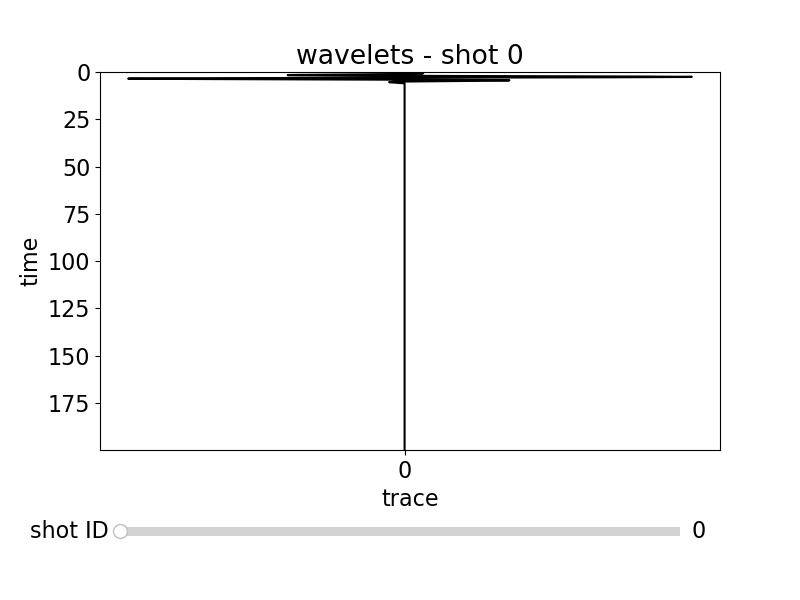

<IPython.core.display.Javascript object>


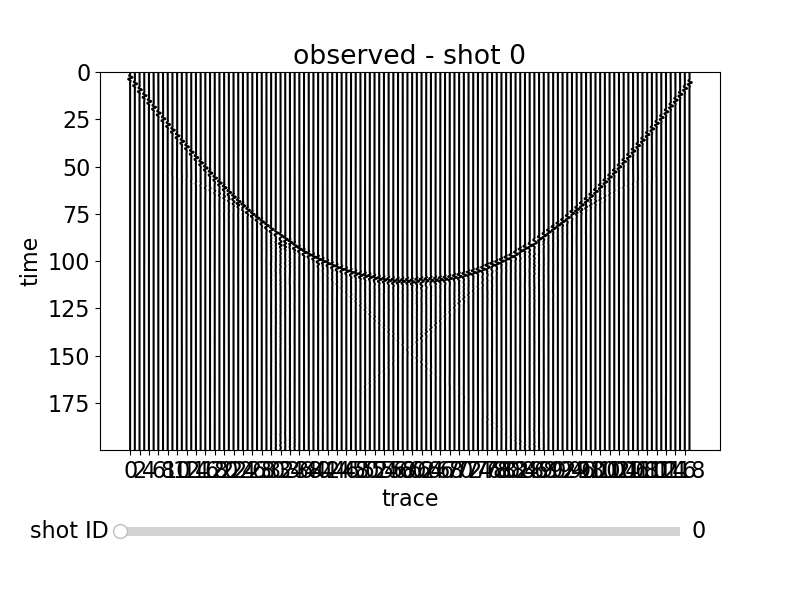

In [9]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp_true,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    runtime.logger.info('Retrieved traces for shot %d' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

# Plot the result
_ = problem.acquisitions.plot()

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward()`:

In [10]:
from stride import forward

# Run default forward workflow
# await forward(problem, pde, vp_true, dump=False)  # uncomment to run using utility function

## Starting model

Before we can proceed with the imaging process, we need to determine a starting point for our inversion, a starting model.

In [11]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can also see that the field has now been instantiated using `parameter()`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

## Imaging operators

Apart from our PDE operator, which we have already defined above, we will need to define an operator for our loss function:

In [12]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

We will also need some operators to proprocess the source wavelents and the modelled and observed data traces:

In [13]:
from stride import ProcessWavelets, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

Finally, we will need an optimiser to update the speed of sound model after each iteration. In this case, we use gradient descent.

In [14]:
from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

## Inverse problem - Estimating speed of sound

We can now proceed to solve the inverse problem, that is finding the speed of sound that explains the data that we have generated above.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 15 shots will be used for each iteration, and they will be selected randomly without replacement.

HEAD            Starting iteration 1 (out of 4), block 1 (out of 2)
HEAD            Giving shot 3 to worker:0:0
HEAD            Giving shot 9 to worker:0:1
WORKER:0:0      (ShotID 3) Preparing to run state for shot
WORKER:0:0      (ShotID 3) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 3) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 3) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 3) Selected undersampling level 4
WORKER:0:0      (ShotID 3) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 9) Preparing to run state for shot
WORKER:0:1      (ShotID 9) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 9) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 9) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0

WORKER:0:1              * fuse: 1.07 s (21.7 %)
WORKER:0:1        * lowering.IET: 1.24 s (25.1 %)
WORKER:0:1      Flops reduction after symbolic optimization: [382 --> 266]
WORKER:0:0      Operator `acoustic_iso_adjoint` generated in 5.09 s
WORKER:0:0        * lowering.Clusters: 3.16 s (62.1 %)
WORKER:0:0           * specializing.Clusters: 2.42 s (47.6 %)
WORKER:0:0              * fuse: 1.15 s (22.6 %)
WORKER:0:0        * lowering.IET: 1.32 s (26.0 %)
WORKER:0:0      Flops reduction after symbolic optimization: [382 --> 266]
WORKER:0:1      Operator `acoustic_iso_adjoint` fetched `/tmp/devito-jitcache-uid1000/d4854c55d613f9224510c24a163ea89d101e74a7.c` in 0.14 s from jit-cache
WORKER:0:1      (ShotID 9) Running adjoint equation for shot
WORKER:0:0      Operator `acoustic_iso_adjoint` fetched `/tmp/devito-jitcache-uid1000/d4854c55d613f9224510c24a163ea89d101e74a7.c` in 0.13 s from jit-cache
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 3) Running adjoint e

HEAD            Functional value for shot 33: loss 1.927051e+00 for shot 33
WORKER:0:1      (ShotID 33) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 33) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.77 s
WORKER:0:0      Global performance: [OI=0.01, 52.09 GFlops/s, 0.72 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section1<2499,376,405> ran in 0.32 s [OI=2.82, 41.99 GFlops/s, 1.20 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.26 s [OI=0.01, 31.53 GFlops/s, 0.69 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 6.87 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 35.90 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * s

WORKER:0:0        * section4<2499,456,485> ran in 0.13 s [OI=0.59, 30.02 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section6<2499,456,485> ran in 0.10 s [OI=1.25, 59.59 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 35) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 35
HEAD            Giving shot 63 to worker:0:0
WORKER:0:0      (ShotID 63) Preparing to run state for shot
WORKER:0:0      (ShotID 63) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 63) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm

WORKER:0:0      (ShotID 70) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 70) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 70) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 70) Selected undersampling level 4
WORKER:0:0      (ShotID 70) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 70) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not

WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.80 s
WORKER:0:1      Global performance: [OI=0.01, 50.14 GFlops/s, 0.70 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.33 s [OI=2.82, 41.47 GFlops/s, 1.19 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.26 s [OI=0.01, 31.48 GFlops/s, 0.69 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.02 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.12 s [OI=0.59, 32.42 GFlops/s, 0.00 GPts/s]
WORKER:0:1        

WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 12.62 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 105) Completed state equation run for shot
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.91 s
WORKER:0:1      Global performance: [OI=0.01, 44.08 GFlops/s, 0.61 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.40 s [OI=2.82, 34.09 GFlops/s, 0.98 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.30 s [OI=0.01, 26.64 GFlops/s, 0.58 GPts/s]
WORKER:0:1        

WORKER:0:0      Operator `acoustic_iso_state` ran in 0.59 s
WORKER:0:0      Global performance: [OI=0.01, 36.13 GFlops/s, 0.94 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.31 s [OI=2.82, 43.42 GFlops/s, 1.25 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.24 s [OI=0.01, 33.45 GFlops/s, 0.73 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.14 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 12.28 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 111) Completed stat

WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section1<2499,376,405> ran in 0.26 s [OI=2.82, 51.26 GFlops/s, 1.47 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.22 s [OI=0.01, 37.50 GFlops/s, 0.82 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 8.00 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 36.57 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section6<2499,456,485> ran in 0.09 s [OI=1.25, 66.96 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthrea

WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 8) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 8
HEAD            Giving shot 31 to worker:0:0
WORKER:0:0      (ShotID 31) Preparing to run state for shot
WORKER:0:0      (ShotID 31) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 31) Spatial grid spacing (0.500 mm | 4.057 PPW) is higher than dispersion limit (0.406 mm | 5.000 PPW)
WORKER:0:0      (ShotID 31) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:0      (ShotID 31) Selected undersampling level 4
WORKER:0:0      (ShotID 31) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 31) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.

WORKER:0:0      (ShotID 40) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 40) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.78 s
WORKER:0:1      Global performance: [OI=0.01, 51.43 GFlops/s, 0.71 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.32 s [OI=2.82, 42.63 GFlops/s, 1.22 GPts/s]


WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.34 s [OI=2.82, 39.25 GFlops/s, 1.13 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.27 s [OI=0.01, 30.10 GFlops/s, 0.66 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.17 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.12 s [OI=0.59, 33.74 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section6<2499,456,485> ran in 0.10 s [OI=1.25, 60.82 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance

WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 49) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 49
HEAD            Giving shot 89 to worker:0:1
WORKER:0:1      (ShotID 89) Preparing to run state for shot
WORKER:0:1      (ShotID 89) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 89) Spatial grid spacing (0.500 mm | 4.057 PPW) is higher than dispersion limit (0.406 mm | 5.000 PPW)
WORKER:0:1      (ShotID 89) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:1      (ShotID 89) Selected undersampling level 4
WORKER:0:1      (ShotID 89) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 89) Running state equation for shot
WORKE

WORKER:0:1      (ShotID 100) Selected undersampling level 4
WORKER:0:1      (ShotID 100) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 100) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:1      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<> ran in 0.01 s 
WORKER:0:1        * section1<> ran in 0.05 s 
WORKER:0:1        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.59 s
WORKER:0:0      Global performance: [OI=0.01, 36.13 GFlops/s, 0.94 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.31 s [OI=2.82, 43.67 GFlops/s, 1.25 GPts/s]
WORKER:0:0        * sect

WORKER:0:0      (ShotID 115) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.46 s
WORKER:0:0      Global performance: [OI=0.01, 87.20 GFlops/s, 1.21 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section1<2499,376,405> ran in 0.22 s [OI=2.82, 63.32 GFlops/s, 1.81 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.17 s [OI=0.01, 47.61 GFlops/s, 1.04 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=16.88, 9.80 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section4<2499,456,485> ran in 0.04 s [OI=0.59, 97.81 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section6<2499,456,485> ran in 0.04 s 

WORKER:0:0      (ShotID 19) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 19) Spatial grid spacing (0.500 mm | 4.050 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:0      (ShotID 19) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:0      (ShotID 19) Selected undersampling level 4
WORKER:0:0      (ShotID 19) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 19) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not

WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.78 s
WORKER:0:1      Global performance: [OI=0.01, 51.43 GFlops/s, 0.71 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.32 s [OI=2.82, 42.30 GFlops/s, 1.21 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 31.88 GFlops/s, 0.70 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 6.85 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.12 s [OI=0.59, 33.80 GFlops/s, 0.00 GPts/s]
WORKER:0:1        

WORKER:0:1        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 35.64 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section6<2499,456,485> ran in 0.09 s [OI=1.25, 66.84 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 56) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 56
HEAD            Giving shot 66 to worker:0:1
WORKER:0:1      (ShotID 66) Preparing to run state for shot
WORKER:0:1      (ShotID 66) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 66) Spatial grid spacing (0.500 mm | 4.050 PPW) is higher than dispersion limit (0.405 mm

WORKER:0:1      (ShotID 80) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 80) Spatial grid spacing (0.500 mm | 4.050 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:1      (ShotID 80) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:1      (ShotID 80) Selected undersampling level 4
WORKER:0:1      (ShotID 80) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 80) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:1      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<> ran in 0.01 s 
WORKER:0:1        * section1<> ran in 0.05 s 
WORKER:0:1        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:1      AutoTuner: could not

WORKER:0:1        * section1<> ran in 0.05 s 
WORKER:0:1        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.55 s
WORKER:0:0      Global performance: [OI=0.01, 38.76 GFlops/s, 1.01 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.28 s [OI=2.82, 47.71 GFlops/s, 1.37 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.22 s [OI=0.01, 36.56 GFlops/s, 0.80 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 13.25 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0    

WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 10.75 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 110) Completed state equation run for shot
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.61 s
WORKER:0:1      Global performance: [OI=0.01, 34.95 GFlops/s, 0.91 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.32 s [OI=2.82, 42.56 GFlops/s, 1.22 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 32.38 GFlops/s, 0.71 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.14

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 117) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 117
HEAD            Updating variable vp,
HEAD            	 grad before processing in range [-2.004419e-04, 1.631375e-04]
HEAD            	 grad after processing in range [-1.000000e+00, 8.139247e-01]
HEAD            	 variable range before update [1.488524e+03, 1.518496e+03]
HEAD            	 variable range after update [1.484596e+03, 1.524566e+03]
HEAD            Done iteration 3 (out of 4), block 1 (out of 2) - Total loss_freq 1.262842e+01
HEAD            ====================================================================
HEAD            Starting iteration 4 (out of 4), block 1 (out of 2)
HEAD            Giving shot 12 to worker:0:0
HEAD            Giving shot 16 to worker:0:1
WORKER:0:1      (ShotID 16) Preparing to run state for shot
WORKER:0:1      (ShotID 16) Estimated band

WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.36 s [OI=2.82, 37.75 GFlops/s, 1.08 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.28 s [OI=0.01, 28.41 GFlops/s, 0.62 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 6.36 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.15 s [OI=0.59, 26.41 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section6<2499,456,485> ran in 0.12 s [OI=1.25, 48.20 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthrea

WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 32) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 32
HEAD            Giving shot 44 to worker:0:1
WORKER:0:1      (ShotID 44) Preparing to run state for shot
WORKER:0:1      (ShotID 44) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 44) Spatial grid spacing (0.500 mm | 4.040 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:1      (ShotID 44) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:1      (ShotID 44) Selected undersampling level 4
WORKER:0:1      (ShotID 44) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 44) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_init` ran in 

WORKER:0:1      (ShotID 61) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 61) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:1      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<> ran in 0.01 s 
WORKER:0:1        * section1<> ran in 0.05 s 
WORKER:0:1        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.53 s
WORKER:0:0      Global performance: [OI=0.01, 40.22 GFlops/s, 1.05 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.27 s [OI=2.82, 49.72 GFlops/s, 1.43 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> 

WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.32 s [OI=2.82, 42.21 GFlops/s, 1.21 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 32.67 GFlops/s, 0.72 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.14 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 11.67 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 71) Completed state equation run for shot
HEAD            Functional value for shot 71: loss 6.814971e-01 for shot 71
WORKER:0:0      (ShotID 71) Preparin

WORKER:0:0      (ShotID 83) Completed state equation run for shot
HEAD            Functional value for shot 83: loss 9.247688e-01 for shot 83
WORKER:0:0      (ShotID 83) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 83) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.54 s
WORKER:0:1      Global performance: [OI=0.01, 39.48 GFlops/s, 1.03 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.28 s [OI=2.82, 48.63 GFlops/s, 1.39 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.22 s [OI=0.01, 36.77 GFlops/s, 0.80 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 12.38 GFlops/s, 0.00 GPts/

WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 13.15 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section4<> ran in 0.04 s 
WORKER:0:1        * section5<> ran in 0.01 s 
WORKER:0:1        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 103) Completed state equation run for shot
HEAD            Functional value for shot 103: loss 6.187785e-01 for shot 103
WORKER:0:1      (ShotID 103) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 103) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.89 s
WORKER:0:0      Global performance: [OI=0.01, 45.07 GFlops/s, 0.63 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPt

WORKER:0:0      (ShotID 2) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 2) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 17) Preparing to run state for shot
WORKER:0:1      (ShotID 17) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 17) Spatial grid spacing (0.500 mm | 4.038 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:1      (ShotID 17) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:1      (ShotID 17) Selected undersampling level 4
WORKER:0:1      (ShotID 17) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 17) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.08 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 6.92 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER

WORKER:0:0      (ShotID 27) Spatial grid spacing (0.500 mm | 4.038 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:0      (ShotID 27) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 27) Selected undersampling level 4
WORKER:0:0      (ShotID 27) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 27) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.50 s
WORKER:0:1   

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.53 s
WORKER:0:1      Global performance: [OI=0.01, 40.22 GFlops/s, 1.05 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.27 s [OI=2.82, 50.12 GFlops/s, 1.44 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.22 s [OI=0.01, 37.54 GFlops/s, 0.82 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 12.81 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section4<> ran in 0.04 s 
WORKER:0:1        * section5<> ran in 0.01 s 
WORKER:0:1        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1    

WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 45) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 45) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.57 s
WORKER:0:0      Global performance: [OI=0.01, 37.40 GFlops/s, 0.97 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.29 s [OI=2.82, 46.14 GFlops/s, 1.32 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.23 s [OI=0.01, 35.36 GFlops/s, 0.77 GPts/s]
WORK

WORKER:0:0        * section0<2499,376,405> ran in 0.31 s [OI=2.82, 43.34 GFlops/s, 1.24 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.24 s [OI=0.01, 33.52 GFlops/s, 0.73 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.16 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 13.02 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 53) Completed state equation run for shot
HEAD            Functional value for shot 53: loss 8.897301e-01 for shot 53
WORKER:0:0      (ShotID 53) Preparing to run adjoint for shot
WORKER:0:

WORKER:0:0      (ShotID 76) Completed state equation run for shot
HEAD            Functional value for shot 76: loss 8.799684e-01 for shot 76
WORKER:0:0      (ShotID 76) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 76) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:1      Global performance: [OI=0.01, 59.87 GFlops/s, 0.83 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.28 s [OI=2.82, 47.68 GFlops/s, 1.37 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.23 s [OI=0.01, 35.95 GFlops/s, 0.79 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.43 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0

WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 11.57 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 96) Completed state equation run for shot
WORKER:0:1      (ShotID 101) Preparing to run state for shot
WORKER:0:1      (ShotID 101) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 101) Spatial grid spacing (0.500 mm | 4.038 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:1      (ShotID 101) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:

WORKER:0:1      Operator `acoustic_iso_init` ran in 0.07 s
WORKER:0:1      Global performance: [OI=0.01, 0.01 GFlops/s, 7.91 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1        * section0<> ran in 0.01 s 
WORKER:0:1        * section1<> ran in 0.07 s 
WORKER:0:1        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.55 s
WORKER:0:0      Global performance: [OI=0.01, 38.76 GFlops/s, 1.01 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.29 s [OI=2.82, 47.48 GFlops/s, 1.36 GPts/s]
WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.22 s [OI=0.01, 36.08 GFlops/s, 0.79 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499

WORKER:0:0        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 32.74 GFlops/s, 0.72 GPts/s]
WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.13 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 11.03 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 15) Completed state equation run for shot
HEAD            Functional value for shot 15: loss 9.596466e-01 for shot 15
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.59 s
WORKER:0:1      Global performance: [OI=0.01, 36.13 GFlops/s, 0.94 GPts/s]
WORKER:0:1      Local performanc

HEAD            Functional value for shot 24: loss 1.263119e+00 for shot 24
WORKER:0:0      (ShotID 24) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 24) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.58 s
WORKER:0:1      Global performance: [OI=0.01, 36.76 GFlops/s, 0.96 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.30 s [OI=2.82, 44.42 GFlops/s, 1.27 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.24 s [OI=0.01, 34.12 GFlops/s, 0.75 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 11.39 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section4<> ran in 0.04 s 
WORKER:0:1       

WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 11.62 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section4<> ran in 0.04 s 
WORKER:0:1        * section5<> ran in 0.01 s 
WORKER:0:1        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 65) Completed state equation run for shot
HEAD            Functional value for shot 65: loss 8.320736e-01 for shot 65
WORKER:0:1      (ShotID 65) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 65) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.74 s
WORKER:0:0      Global performance: [OI=0.01, 54.21 GFlops/s, 0.75 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]


WORKER:0:0      Global performance: [OI=0.01, 52.78 GFlops/s, 0.73 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section1<2499,376,405> ran in 0.30 s [OI=2.82, 44.62 GFlops/s, 1.28 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 32.99 GFlops/s, 0.72 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.05 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section4<2499,456,485> ran in 0.12 s [OI=0.59, 33.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section6<2499,456,485> ran in 0.09 s [OI=1.25, 64.77 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section8<2499> ran 

WORKER:0:0        * section6<2499,456,485> ran in 0.09 s [OI=1.25, 68.85 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 91) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 91
HEAD            Giving shot 97 to worker:0:0
WORKER:0:0      (ShotID 97) Preparing to run state for shot
WORKER:0:0      (ShotID 97) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 97) Spatial grid spacing (0.500 mm | 4.027 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:0      (ShotID 97) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 97) Selected undersampling level 4
WORKER:0:0      (ShotID 97) Sel

WORKER:0:0      (ShotID 113) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 113) Selected undersampling level 4
WORKER:0:0      (ShotID 113) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 113) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.87 s
WORKER:0:1      Global performance: [OI=0.01, 46.11 GFlops/s, 0.64 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * sect

WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 1) Completed state equation run for shot
HEAD            Functional value for shot 1: loss 7.063165e-01 for shot 1
WORKER:0:0      (ShotID 1) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 1) Running adjoint equation for shot
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.56 s
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 38.07 GFlops/s, 0.99 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,376,405> ran in 0.30 s [OI=2.82, 45.81 GFlops/s, 1.31 GPts/s]
WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.23 s [OI=0.01, 35.62 GFlops/s, 0.78 GPts/s]
WORKER

WORKER:0:1        * section1<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.24 s [OI=0.01, 33.03 GFlops/s, 0.72 GPts/s]
WORKER:0:1        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 13.71 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section4<> ran in 0.04 s 
WORKER:0:1        * section5<> ran in 0.01 s 
WORKER:0:1        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 28) Completed state equation run for shot
WORKER:0:0      AutoTuner: could not perform any runs
HEAD            Functional value for shot 28: loss 1.262264e+00 for shot 28
WORKER:0:1      (ShotID 28) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 28) Running adjoint equatio

HEAD            Functional value for shot 59: loss 6.926833e-01 for shot 59
WORKER:0:1      (ShotID 59) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 59) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.74 s
WORKER:0:0      Global performance: [OI=0.01, 54.21 GFlops/s, 0.75 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section1<2499,376,405> ran in 0.31 s [OI=2.82, 44.07 GFlops/s, 1.26 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 32.84 GFlops/s, 0.72 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.08 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 38.10 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * s

WORKER:0:0        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 38.67 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section6<2499,456,485> ran in 0.08 s [OI=1.25, 73.52 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 64) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 64
HEAD            Giving shot 75 to worker:0:0
WORKER:0:0      (ShotID 75) Preparing to run state for shot
WORKER:0:0      (ShotID 75) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 75) Spatial grid spacing (0.500 mm | 4.026 PPW) is higher than dispersion limit (0.403 mm

WORKER:0:1        * section5<> ran in 0.01 s 
WORKER:0:1        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 84) Completed state equation run for shot
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.05 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 11.07 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
HEAD            Functional value for shot 84: loss 1.184131e+00 for shot 84
WORKER:0:1      (ShotID 84) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 84) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could n

WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.69 s
WORKER:0:1      Global performance: [OI=0.01, 58.13 GFlops/s, 0.81 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.29 s [OI=2.82, 47.11 GFlops/s, 1.35 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.23 s [OI=0.01, 35.35 GFlops/s, 0.77 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.35 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.10 s [OI=0.59, 38.71 GFlops/s, 0.00 GPts/s]
WORKER:0:1        

WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 6.60 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 36.30 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section6<2499,456,485> ran in 0.08 s [OI=1.25, 69.64 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 109) Completed adjoint equation run for shot
WORKER:0:0      Global performance: [OI=0.01, 35.53 GFlops/s, 0.93 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,376,405> ran in 0.32 s [OI=2.82, 42.76 GFlops/s, 1.23 GPts/s]
WORKER:0:0 

WORKER:0:1        * section5<> ran in 0.01 s 
WORKER:0:1        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 22) Completed state equation run for shot
HEAD            Functional value for shot 22: loss 1.376215e+00 for shot 22
WORKER:0:1      (ShotID 22) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 22) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.83 s
WORKER:0:0      Global performance: [OI=0.01, 48.33 GFlops/s, 0.67 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section1<2499,376,405> ran in 0.31 s [OI=2.82, 43.30 GFlops/s, 1.24 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s 

WORKER:0:0        * section1<2499,376,405> ran in 0.31 s [OI=2.82, 44.04 GFlops/s, 1.26 GPts/s]
WORKER:0:0        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.25 s [OI=0.01, 32.92 GFlops/s, 0.72 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.23 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section4<2499,456,485> ran in 0.11 s [OI=0.59, 36.69 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section6<2499,456,485> ran in 0.08 s [OI=1.25, 69.88 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 26) Completed adjoint equat

WORKER:0:0        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 37) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 37
HEAD            Giving shot 52 to worker:0:0
WORKER:0:0      (ShotID 52) Preparing to run state for shot
WORKER:0:0      (ShotID 52) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 52) Spatial grid spacing (0.500 mm | 4.009 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:0      (ShotID 52) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:0      (ShotID 52) Selected undersampling level 4
WORKER:0:0      (ShotID 52) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 52) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 

WORKER:0:0      (ShotID 57) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 57) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_init` ran in 0.06 s
WORKER:0:0      Global performance: [OI=0.01, 0.01 GFlops/s, 9.22 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<> ran in 0.01 s 
WORKER:0:0        * section1<> ran in 0.05 s 
WORKER:0:0        * section2<2501> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3}
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.82 s
WORKER:0:1      Global performance: [OI=0.01, 48.92 GFlops/s, 0.68 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.34 s [OI=2.82, 39.34 GFlops/s, 1.13 GPts/s]
W

WORKER:0:1      Local performance:
WORKER:0:1        * section0<3> ran in 0.01 s [OI=0.13, 0.01 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section1<2499,376,405> ran in 0.29 s [OI=2.82, 46.07 GFlops/s, 1.32 GPts/s]
WORKER:0:1        * section2<<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.23 s [OI=0.01, 34.60 GFlops/s, 0.76 GPts/s]
WORKER:0:1        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=16.88, 7.44 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section4<2499,456,485> ran in 0.12 s [OI=0.59, 33.66 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section5<2499,456,485> ran in 0.01 s [OI=0.88, 3868751.89 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section6<2499,456,485> ran in 0.09 s [OI=1.25, 62.92 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance

WORKER:0:1        * section7<2499,456,485> ran in 0.01 s [OI=2.50, 5526788.40 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section8<2499> ran in 0.01 s [OI=0.25, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 99) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 99
HEAD            Giving shot 112 to worker:0:1
WORKER:0:1      (ShotID 112) Preparing to run state for shot
WORKER:0:1      (ShotID 112) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 112) Spatial grid spacing (0.500 mm | 4.009 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:1      (ShotID 112) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:1      (ShotID 112) Selected undersampling level 4
WORKER:0:1      (ShotID 112) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 112) Running state equation for sh

WORKER:0:0        * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=15.63, 0.15 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section3<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=21.50, 12.12 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section4<> ran in 0.04 s 
WORKER:0:0        * section5<> ran in 0.01 s 
WORKER:0:0        * section6<2499> ran in 0.01 s [OI=0.13, 2.50 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 114) Completed state equation run for shot
HEAD            Functional value for shot 114: loss 1.015981e+00 for shot 114
WORKER:0:0      (ShotID 114) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 114) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.48 s
WORKER:0:0      Global performance: [OI=0.01, 83.57 GFlops/s,

<IPython.core.display.Javascript object>


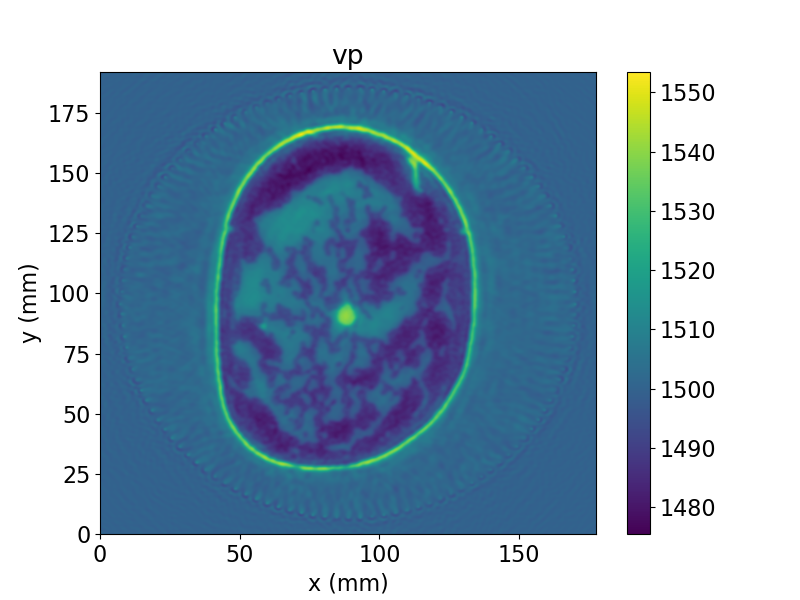

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [15]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
f_min = 0.05e6
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=15, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets
            wavelets = process_wavelets(wavelets, f_min=f_min, f_max=f_max, runtime=worker)
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, f_min=f_min, f_max=f_max, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss_freq function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_fun(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss_freq %e' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks, iteration.fun_value))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [16]:
# uncomment to run using utility function
# for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
#     await adjoint(problem, pde, loss_freq,
#                   optimisation_loop, optimiser, vp,
#                   num_iters=num_iters,
#                   select_shots=dict(num=15, randomly=True),
#                   f_min=0.05e6, f_max=freq)

# vp.plot()

Before closing, we should tear down the mosaic runtime:

In [17]:
await mosaic.interactive('off')